# [INFO-H515 - Big Data Scalable Analytics](https://uv.ulb.ac.be/course/view.php?id=85246?username=guest)

## TP 7 - Feature selection with Map/Reduce on Google Cloud

*Materials originally developed by Yann-Aël Le Borgne and Gianluca Bontempi*

#### *Theo Verhelst, Daniele Lunghi and Gianluca Bontempi*

####  Date: TBD

This notebook is to be executed with Google DataProc. See details in TP 7 - Spark, HDFS and Jupyter notebooks on Google Cloud.

In [1]:
import time
import os 
import numpy as np
import scipy.stats

import sklearn
import sklearn.datasets

import pandas as pd

%matplotlib notebook  
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession


# 1) Dataset generation

Let us start by generating a dataset of synthetic data where input data contains informative but also redudant and noisy features. The goal of our feature selection methods will be to identify informative features and discard noisy ones. 

The dataset is generated by the `generate_dataset` function below. It takes as input

* `n_samples`: Number of observations $N$
* `n_informative`: Number of informative features
* `n_noisy`: Number of noisy features
* `n_redundant`: Number of redundant features
* `random_seed`: A random seed for reproducibility

The function returns a matrix $X$ of size $N \times n$ ($N$ observations, (rows) and $n$ features (columns)), and an output vector $Y$. The total number of features $n$ is the sum of the informative, redundant and noisy features. 

Internally, the function relies on the [`sklearn.datasets.make_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) function for generating a dataset where the output is correlated with the informative features. The `generate_dataset` function further adds redundant features by means of linear combinations of the informative features.  

In [2]:
def generate_dataset(n_samples=100, n_informative=1, n_noisy=2, n_redundant=1, random_seed=0):
    
    # Set random seed
    np.random.seed(random_seed)
    
    # Use sklearn.datasets.make_regression to generate an artificial dataset where the output y 
    # is correlated with a subset of of the input features
    X, Y = sklearn.datasets.make_regression(n_samples=n_samples, 
                                            n_features=n_informative+n_noisy, 
                                            n_informative=n_informative)
    
    # Create a random mixing matrix for generating redundant features from informative ones
    mixing_matrix = np.random.random((n_informative, n_redundant))
    
    # Create redundant features by taking random linear combinations of informative features
    redundant_features = np.dot(X[:,0:n_informative], mixing_matrix)
    
    # Add redundant features to the input data
    X = np.concatenate((X, redundant_features), axis=1)
    
    # Return input data X, output data Y
    return X, Y

Let us for example generate with 1000 observations and 10000 informative features, 10000 noisy features and 10000 redundant features (30000 features in total).

In [3]:
# Let us generate the dataset
N = 1000
n_informative = 10000
n_noisy = 10000
n_redundant = 10000

X, Y = generate_dataset(n_samples=N, 
                        n_informative=n_informative, 
                        n_noisy=n_noisy, 
                        n_redundant=n_redundant)



Let us check the size of the input and output data:

In [4]:
# Input data contains 1000 observations and 30000 features
X.shape

(1000, 30000)

In [5]:
# Output data contains 1000 values
Y.shape

(1000,)

# 2)  Feature ranking with mRMR and correlation

Algorithm description is removed for clarity. See the original notebook on feature selection to find explanations about the implementation. 


## 2.1) Centralized approach

The implementation is the same as in the original notebook, except for the addition of a lost to keep track of the execution time for each step of the mRMR algorithm.

In [6]:
# X: Input data
# Y: Output data
# K: Number of features to select
def get_top_K_features_mRMR(X,Y,K=2):
    
    execution_times = []
    
    n_total_features = X.shape[1]

    # At first, all features are considered (remaining features contains all indices)
    remaining_features_indices = list(range(n_total_features))
    # and no feature are selected
    selected_features_indices = []

    # Loop for selecting K features iteratively
    for k in range(K):
        print("Step: "+str(k))
        start_time=time.time()
    
        # Retrieve values of selected features
        selected_features_values = X[:,selected_features_indices]
        n_remaining_features = len(remaining_features_indices)
        
        # Set scores for remaining features to 0
        score_features = np.zeros(n_remaining_features, dtype=float)

        # For each remaining feature
        for r in range(n_remaining_features):
        
            # Get feature index
            feature_r = remaining_features_indices[r]
        
            # Compute mRMR score for that feature
            score_r = get_mrmr_score(X[:,feature_r], Y, selected_features_values)
        
            # Store score 
            score_features[r] = score_r
    
        # Select feature with highest score
        index_max_score_features = np.argmax(score_features)
    
        # Add feature to selected features
        selected_features_indices.append(remaining_features_indices[index_max_score_features])
    
        # Remove feature from remaining features
        del(remaining_features_indices[index_max_score_features])
        print(time.time()-start_time)
        execution_times.append(time.time()-start_time)
        
    return selected_features_indices, execution_times
    

In [7]:
def get_score(x, y):
    
    score = np.abs(scipy.stats.pearsonr(x, y)[0])
    
    return score

In [8]:
# x: Feature to assess (X_j)
# y: Output feature
# selected_features_values: Array of size n_selected_features*N of already selected features
def get_mrmr_score(x, y, selected_features_values):
    
    # Get correlation score between feature x and output y (relevance)
    score_x_y_s = get_score(x, y)
    
    n_selected_features = selected_features_values.shape[1]
    
    # If some features have already been selected
    if n_selected_features>0:
        
        # Get corrrelation scores between x and each feature already selected (redundancy)
        score_features_x_s = np.zeros(n_selected_features, dtype=float)
        
        for j in range(n_selected_features):
                
            score_x_s_j = get_score(x, selected_features_values[:,j])
                
            score_features_x_s[j] = score_x_s_j
                
        # Final score is relevance to output feature - average redundancy with already selected features
        score_x_y_s = score_x_y_s - np.mean(score_features_x_s)
        
    return score_x_y_s

Let us compute the five most relevant features with mRMR:

In [9]:
K=10
selected_features_indices, execution_times_centralized = get_top_K_features_mRMR(X,Y,K=K)

Step: 0
2.712233781814575
Step: 1
5.772610664367676
Step: 2
8.38382339477539
Step: 3
11.058805227279663
Step: 4
13.826265573501587
Step: 5
16.23865842819214
Step: 6
19.146735429763794
Step: 7
21.64142417907715
Step: 8
24.26274013519287
Step: 9
26.851195812225342


The time to select a feature linearly increases with the number of features, each step taking on average 2.5 seconds more than the previous step. 

<IPython.core.display.Javascript object>


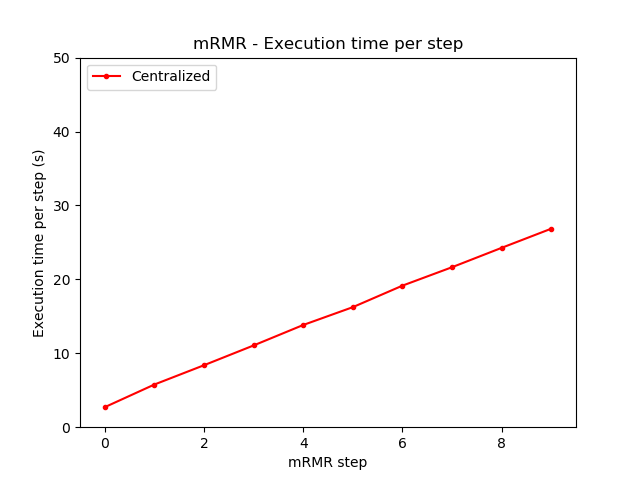

In [32]:
fig_execution_times1, ax = plt.subplots()
ax.plot(range(K), execution_times_centralized, label='Centralized', color='r', marker=".")
ax.set_xlabel('mRMR step')
ax.set_ylabel('Execution time per step (s)')
ax.set_title('mRMR - Execution time per step')
ax.set_xlim([-0.5, 9.5])
ax.set_ylim([0, 50])
ax.legend(loc='upper left')

Let us check which features were selected:

In [11]:
selected_features_indices

[25945, 13589, 18004, 29260, 9355, 25002, 18089, 26045, 126, 18045]

## 2.2) Map/Reduce approach using Spark

Let us use the same implementation as in the original notebook, using the transpose of X for performing feature selection. 

In [12]:
t_X = np.transpose(X)

In [13]:
t_X.shape

(30000, 1000)

In [14]:
# x: Feature to assess
# Broadcasted values:
# broadcast_y: Output feature
# broadcast_selected_features_values: Array of size n_selected_features*N of already selected features
def get_mrmr_score_spark(x):
    
    # Retrieve content of broadcasted values
    y = broadcast_y.value
    selected_features_values = broadcast_selected_features_values.value
    
    # Get correlation score between feature x and output y (relevance)
    score_x_y_s = get_score(x, y)
    
    n_selected_features = selected_features_values.shape[0]
    
    # If some features have already been selected
    if n_selected_features>0:
        
        # Get corrrelation scores between x and each feature already selected (redundancy)
        score_features_x_s = np.zeros(n_selected_features, dtype=float)
        
        for j in range(n_selected_features):
                
            score_x_s_j = get_score(x, selected_features_values[j,:])
                
            score_features_x_s[j] = score_x_s_j
                
        # Final score is relevance to output feature - average redundancy with already selected features
        score_x_y_s = score_x_y_s - np.mean(score_features_x_s)
        
    return score_x_y_s

In [15]:
def mrmr_spark(n_total_features, K, sc, X_RDD, Y):

    remaining_features_indices = list(range(n_total_features))
    selected_features_indices = []

    broadcast_y = sc.broadcast(Y)

    for k in range(K):
        print("Step: "+str(k))
    
        start_time=time.time()

        # Get the subset of selected features values, and cast as an array
        selected_features_values = X_RDD.zipWithIndex().filter(lambda x: x[1] in selected_features_indices).map(lambda x: x[0]).collect()
        selected_features_values = np.array(selected_features_values)
        
        # Broadcast selected_features_values 
        broadcast_selected_features_values = sc.broadcast(selected_features_values)
    
        # mRMR scores are computed by first filtering `t_X` to remove already selected features, and then mapping 
        # each remaining feature using the `get_mrmr_score_spark` function
        scores = X_RDD.zipWithIndex().filter(lambda x: x[1] in remaining_features_indices).map(lambda x:get_mrmr_score_spark(x[0])).collect()
    
        # Once all mRMR scores are computed, the index of the feature with the highest score is selected as 
        # in the centralized implementation.
        scores = np.array(scores)
    
        index_max_score_features = np.argmax(scores)
    
        selected_features_indices.append(remaining_features_indices[index_max_score_features])
    
        del(remaining_features_indices[index_max_score_features])
    
        print(time.time()-start_time)
        
    return selected_features_indices

We start a Spark session with `yarn` as the master. The following configuration paramaters are of interest:

* `spark.dynamicAllocation.enabled` : It should be set to false to force the right number of executors and cores. If true, DataProc may dynamically change the number of executors or cores.
* `spark.executor.instances`: There are two instances in the cluster, so it can be either 1 or 2.
* `spark.executor.cores`: There are 8 cores per instance in the cluster, so this number must be between 1 and 8.
* `spark.executor.memory`: 8GB is sufficient for running this example



### Spark with 1 instance and 1 core

Let us first run the mRMR feature selection with 1 instance and 1 core, for selecting the top 10 features.

In [16]:
spark = SparkSession \
    .builder \
    .master("yarn") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.memory", "8G") \
    .appName("FeatureSelection") \
    .getOrCreate()

# Let us retrieve the sparkContext object
sc=spark.sparkContext

In [17]:
#Let us use 16 partitions
B=16
X_RDD=sc.parallelize(t_X,B).cache()

# Counting the number of rows will allow to implicitly cache the data
X_RDD.count()

30000

In [18]:
n_total_features = t_X.shape[0]
K = 10

In [19]:
execution_times_spark_1_1 = []

remaining_features_indices = list(range(n_total_features))
selected_features_indices = []

broadcast_y = sc.broadcast(Y)

for k in range(K):
    print("Step: "+str(k))
    
    start_time=time.time()

    # Get the subset of selected features values, and cast as an array
    selected_features_values = X_RDD.zipWithIndex().filter(lambda x: x[1] in selected_features_indices).map(lambda x: x[0]).collect()
    selected_features_values = np.array(selected_features_values)
        
    # Broadcast selected_features_values 
    broadcast_selected_features_values = sc.broadcast(selected_features_values)
    
    # mRMR scores are computed by first filtering `t_X` to remove already selected features, and then mapping 
    # each remaining feature using the `get_mrmr_score_spark` function
    scores = X_RDD.zipWithIndex().filter(lambda x: x[1] in remaining_features_indices).map(lambda x:get_mrmr_score_spark(x[0])).collect()
    
    # Once all mRMR scores are computed, the index of the feature with the highest score is selected as 
    # in the centralized implementation.
    scores = np.array(scores)
    
    index_max_score_features = np.argmax(scores)
    
    selected_features_indices.append(remaining_features_indices[index_max_score_features])
    
    del(remaining_features_indices[index_max_score_features])
    
    print(time.time()-start_time)
    execution_times_spark_1_1.append(time.time()-start_time)
        


Step: 0
16.973361015319824
Step: 1
19.073850870132446
Step: 2
21.15679907798767
Step: 3
23.70885729789734
Step: 4
26.16200613975525
Step: 5
28.713074207305908
Step: 6
31.299360513687134
Step: 7
33.8443284034729
Step: 8
36.0463981628418
Step: 9
38.9834201335907


In [20]:
spark.stop()

The overhead of Spark and Yarn makes the execution around 15 seconds longer for each step of the algorithm. The increase of execution time for each new selected feature is the same as the centralized approach, that is, around 2.5 seconds. 

<IPython.core.display.Javascript object>


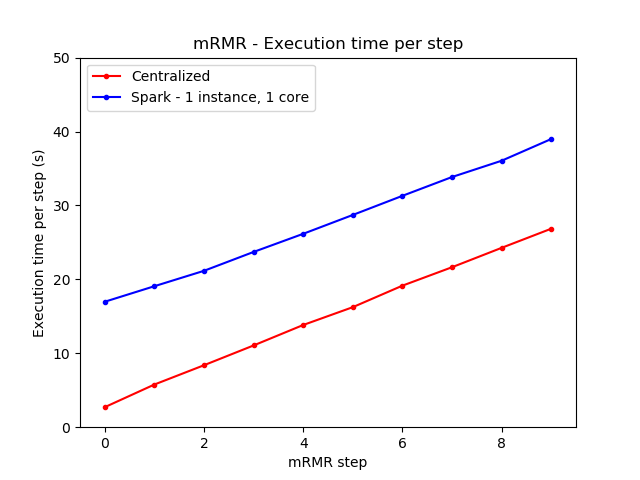

In [33]:
fig_execution_times2, ax = plt.subplots()
ax.plot(range(K), execution_times_centralized, label='Centralized', color='r', marker=".")
ax.plot(range(K), execution_times_spark_1_1, label='Spark - 1 instance, 1 core', color='b', marker=".")
ax.set_xlabel('mRMR step')
ax.set_ylabel('Execution time per step (s)')
ax.set_title('mRMR - Execution time per step')
ax.set_xlim([-0.5, 9.5])
ax.set_ylim([0, 50])
ax.legend(loc='upper left')


We can check that the selected features are the same as with the centralized approach.

In [22]:
selected_features_indices

[25945, 13589, 18004, 29260, 9355, 25002, 18089, 26045, 126, 18045]

### Spark with 2 instances and 8 cores

Let us then run the mRMR feature selection with 2 instances and 8 cores, for selecting the top 10 features.

In [23]:
spark = SparkSession \
    .builder \
    .master("yarn") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "8") \
    .config("spark.executor.memory", "8G") \
    .appName("FeatureSelection") \
    .getOrCreate()

# Let us retrieve the sparkContext object
sc=spark.sparkContext

In [24]:
#Let us use 16 partitions
B=16
X_RDD=sc.parallelize(t_X,B).cache()

# Counting the number of rows will allow to implicitly cache the data
X_RDD.count()

30000

In [25]:
execution_times_spark_2_8 = []

n_total_features = t_X.shape[0]
K = 10

remaining_features_indices = list(range(n_total_features))
selected_features_indices = []

broadcast_y = sc.broadcast(Y)

for k in range(K):
    print("Step: "+str(k))
    
    start_time=time.time()

    # Get the subset of selected features values, and cast as an array
    selected_features_values = X_RDD.zipWithIndex().filter(lambda x: x[1] in selected_features_indices).map(lambda x: x[0]).collect()
    selected_features_values = np.array(selected_features_values)
        
    # Broadcast selected_features_values 
    broadcast_selected_features_values = sc.broadcast(selected_features_values)
    
    # mRMR scores are computed by first filtering `t_X` to remove already selected features, and then mapping 
    # each remaining feature using the `get_mrmr_score_spark` function
    scores = X_RDD.zipWithIndex().filter(lambda x: x[1] in remaining_features_indices).map(lambda x:get_mrmr_score_spark(x[0])).collect()
    
    # Once all mRMR scores are computed, the index of the feature with the highest score is selected as 
    # in the centralized implementation.
    scores = np.array(scores)
    
    index_max_score_features = np.argmax(scores)
    
    selected_features_indices.append(remaining_features_indices[index_max_score_features])
    
    del(remaining_features_indices[index_max_score_features])
    
    print(time.time()-start_time)
    execution_times_spark_2_8.append(time.time()-start_time)  


Step: 0
5.236647367477417
Step: 1
4.793611288070679
Step: 2
5.061771869659424
Step: 3
5.729682683944702
Step: 4
5.578852415084839
Step: 5
6.189572811126709
Step: 6
6.322348117828369
Step: 7
6.286564588546753
Step: 8
6.936615467071533
Step: 9
7.476357698440552


The tasks are now distributed on the 16 cores available on the two instances. The overhead of Spark and Yarn is reduced. The increase of execution time for each new selected feature is divided by a factor of 10, down to around 0.25 seconds.

<IPython.core.display.Javascript object>


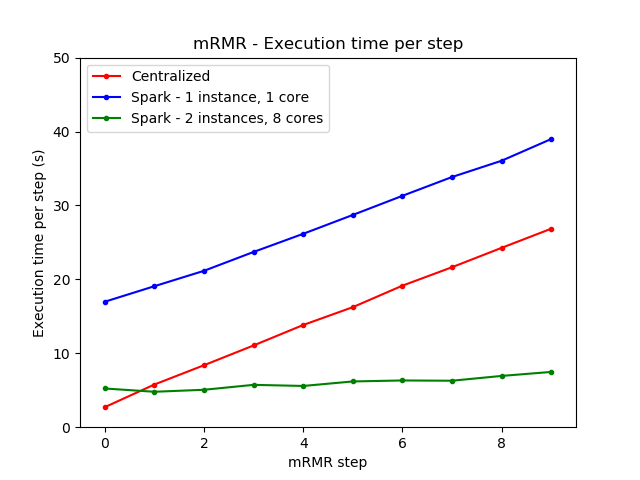

In [34]:
fig_execution_times3, ax = plt.subplots()
ax.plot(range(K), execution_times_centralized, label='Centralized', color='r', marker=".")
ax.plot(range(K), execution_times_spark_1_1, label='Spark - 1 instance, 1 core', color='b', marker=".")
ax.plot(range(K), execution_times_spark_2_8, label='Spark - 2 instances, 8 cores', color='g', marker=".")
ax.set_xlabel('mRMR step')
ax.set_ylabel('Execution time per step (s)')
ax.set_title('mRMR - Execution time per step')
ax.set_xlim([-0.5, 9.5])
ax.set_ylim([0, 50])
ax.legend(loc='upper left')


In [27]:
selected_features_indices

[25945, 13589, 18004, 29260, 9355, 25002, 18089, 26045, 126, 18045]

### Spark with 2 instance and 8 cores, using HDFS

Finally, let us run the same code, but getting the data from HDFS. The data can be saved on HDFS as Python pickle files:


In [28]:
%time X_RDD.saveAsPickleFile('dataset.pkl')

CPU times: user 0 ns, sys: 6.6 ms, total: 6.6 ms
Wall time: 2.42 s


Let us check how the data are stored. We have one file for each partition of the RDD.

In [43]:
!hadoop fs -ls dataset.pkl

Found 17 items
-rw-r--r--   2 root hadoop          0 2022-02-16 19:34 dataset.pkl/_SUCCESS
-rw-r--r--   2 root hadoop    8247640 2022-02-16 19:34 dataset.pkl/part-00000
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00001
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00002
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00003
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00004
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00005
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00006
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00007
-rw-r--r--   2 root hadoop    8247640 2022-02-16 19:34 dataset.pkl/part-00008
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00009
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19:34 dataset.pkl/part-00010
-rw-r--r--   2 root hadoop   16495041 2022-02-16 19

Instead of creating the RDD from the NumPy array, we create it from the data stored on HDFS. The rest of the code is the same.

In [29]:
#Let us use 16 partitions
X_RDD=sc.pickleFile("dataset.pkl").cache()

# Counting the number of rows will allow to implicitly cache the data
X_RDD.count()

30000

In [30]:
execution_times_spark_hdfs_2_8 = []

n_total_features = t_X.shape[0]
K = 10

remaining_features_indices = list(range(n_total_features))
selected_features_indices = []

broadcast_y = sc.broadcast(Y)

for k in range(K):
    print("Step: "+str(k))
    
    start_time=time.time()

    # Get the subset of selected features values, and cast as an array
    selected_features_values = X_RDD.zipWithIndex().filter(lambda x: x[1] in selected_features_indices).map(lambda x: x[0]).collect()
    selected_features_values = np.array(selected_features_values)
        
    # Broadcast selected_features_values 
    broadcast_selected_features_values = sc.broadcast(selected_features_values)
    
    # mRMR scores are computed by first filtering `t_X` to remove already selected features, and then mapping 
    # each remaining feature using the `get_mrmr_score_spark` function
    scores = X_RDD.zipWithIndex().filter(lambda x: x[1] in remaining_features_indices).map(lambda x:get_mrmr_score_spark(x[0])).collect()
    
    # Once all mRMR scores are computed, the index of the feature with the highest score is selected as 
    # in the centralized implementation.
    scores = np.array(scores)
    
    index_max_score_features = np.argmax(scores)
    
    selected_features_indices.append(remaining_features_indices[index_max_score_features])
    
    del(remaining_features_indices[index_max_score_features])
    
    print(time.time()-start_time)
    execution_times_spark_hdfs_2_8.append(time.time()-start_time)    


Step: 0
2.3659234046936035
Step: 1
2.3859615325927734
Step: 2
2.6546998023986816
Step: 3
3.1244888305664062
Step: 4
3.439063787460327
Step: 5
3.693345785140991
Step: 6
3.9535346031188965
Step: 7
4.43225622177124
Step: 8
4.544193267822266
Step: 9
5.050506830215454


The overhead for loading data is reduced. The increase of execution time for each new selected feature remains at around 0.25 seconds. 

<IPython.core.display.Javascript object>


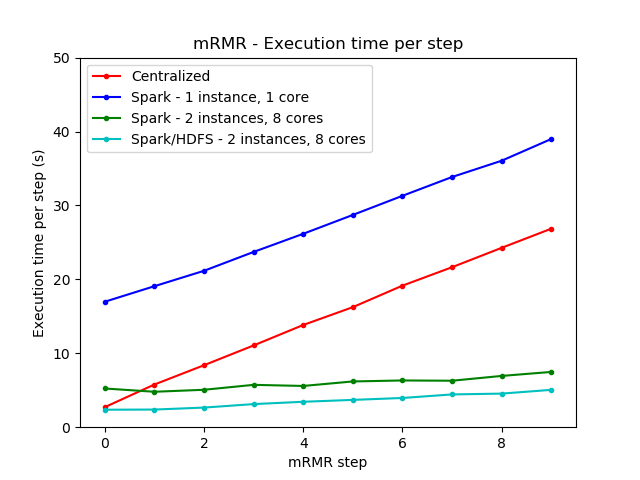

In [35]:
fig_execution_times4, ax = plt.subplots()
ax.plot(range(K), execution_times_centralized, label='Centralized', color='r', marker=".")
ax.plot(range(K), execution_times_spark_1_1, label='Spark - 1 instance, 1 core', color='b', marker=".")
ax.plot(range(K), execution_times_spark_2_8, label='Spark - 2 instances, 8 cores', color='g', marker=".")
ax.plot(range(K), execution_times_spark_hdfs_2_8, label='Spark/HDFS - 2 instances, 8 cores', color='c', marker=".")
ax.set_xlabel('mRMR step')
ax.set_ylabel('Execution time per step (s)')
ax.set_title('mRMR - Execution time per step')
ax.set_xlim([-0.5, 9.5])
ax.set_ylim([0, 50])
ax.legend(loc='upper left')


## Relevant links

* [1] Feature selection in high-dimensional dataset using MapReduce - https://www.researchgate.net/publication/319534526_Feature_selection_in_high-dimensional_dataset_using_MapReduce, https://github.com/creggian/spark-ifs  
* [2] An Introduction to Variable and Feature Selection - https://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf
* [3] Iterative mapreduce for large scale machine learning - https://arxiv.org/pdf/1303.3517
* https://codelabs.developers.google.com/codelabs/spark-jupyter-dataproc#0